In [1]:
#Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
import seaborn as sns
import snowflake.connector
import os
from imblearn.over_sampling import SMOTE

In [2]:
conn = snowflake.connector.connect(
    user=os.getenv('USERNAME_2'),
    password=os.getenv('SNOWSQL_PWD'),
    account=os.getenv('ACCOUNT_NAME'),
    database=os.getenv('DATABASE'),
    schema=os.getenv('SCHEMA'),
    warehouse=os.getenv('WAREHOUSE'),
    login_timeout=60,
    client_session_keep_alive=True 
)

In [3]:
cursor = conn.cursor()
query = """Select msg.is_opened, msg.message_type, msg.channel, msg.subject_with_bonuses, msg.subject_with_deadline, msg.subject_with_discount, msg.subject_with_emoji, msg.subject_with_saleout, msg.subject_length, msg.sent_at
from message_extended as msg
where msg.subject_with_discount is not null;"""
cursor.execute(query)
result = cursor.fetchall()

In [4]:
messages_df = pd.DataFrame(result, columns=[col[0] for col in cursor.description])

In [5]:
cursor.close()
conn.close()
del result, cursor, conn

In [6]:
messages_df['SENT_AT'] = pd.to_datetime(messages_df['SENT_AT'])

In [7]:
messages_df['Hour'] = messages_df['SENT_AT'].dt.hour

In [8]:
def time_periods(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    else:
        return 'Evening'
#Apply the custom function to the 'hour' column and create a new 'period' column
messages_df['TimePeriod'] = messages_df['Hour'].apply(time_periods)

In [9]:
def convert_to_bool(value):
    if value.lower() == 't' or value.lower() == 'true':
        return 1
    elif value.lower() == 'f' or value.lower() == 'false':
        return 0
    return value

In [10]:
#Changing datatypes of mesages dataset (messages_df) attributes
messages_df['IS_OPENED'] = messages_df['IS_OPENED'].apply(convert_to_bool)
messages_df['SUBJECT_WITH_BONUSES'] = messages_df['SUBJECT_WITH_BONUSES'].apply(convert_to_bool)
messages_df['SUBJECT_WITH_DEADLINE'] = messages_df['SUBJECT_WITH_DEADLINE'].apply(convert_to_bool)
messages_df['SUBJECT_WITH_DISCOUNT'] = messages_df['SUBJECT_WITH_DISCOUNT'].apply(convert_to_bool)
messages_df['SUBJECT_WITH_EMOJI'] = messages_df['SUBJECT_WITH_EMOJI'].apply(convert_to_bool)
messages_df['SUBJECT_WITH_SALEOUT'] = messages_df['SUBJECT_WITH_SALEOUT'].apply(convert_to_bool)

In [11]:
#========================Converting the 'message_type' values into dummy variables=================
final_message_df = pd.get_dummies(messages_df, columns=['MESSAGE_TYPE','CHANNEL','TimePeriod'])

In [12]:
def convert_to_int(value):
    if value is True:
        return 1
    else:
        return 0

In [13]:
final_message_df['TimePeriod_Afternoon'] = final_message_df['TimePeriod_Afternoon'].apply(convert_to_int)
final_message_df['TimePeriod_Evening'] = final_message_df['TimePeriod_Evening'].apply(convert_to_int)
final_message_df['TimePeriod_Morning'] = final_message_df['TimePeriod_Morning'].apply(convert_to_int)
final_message_df['TimePeriod_Night'] = final_message_df['TimePeriod_Night'].apply(convert_to_int)

In [15]:
del messages_df

In [16]:
columns = ['SENT_AT', 'Hour', 'CHANNEL_mobile_push']

In [17]:
final_message_df.drop(columns=columns, inplace=True)

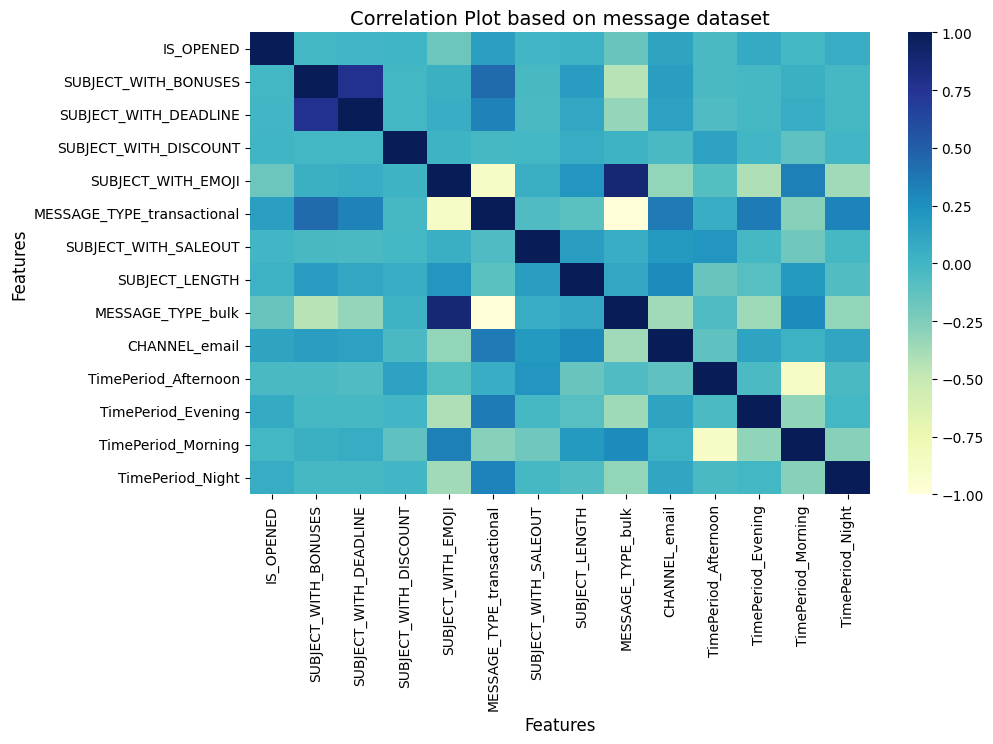

In [19]:
columns = ['IS_OPENED', 'SUBJECT_WITH_BONUSES',
       'SUBJECT_WITH_DEADLINE', 'SUBJECT_WITH_DISCOUNT', 'SUBJECT_WITH_EMOJI','MESSAGE_TYPE_transactional',
       'SUBJECT_WITH_SALEOUT', 'SUBJECT_LENGTH', 'MESSAGE_TYPE_bulk',
       'CHANNEL_email', 'TimePeriod_Afternoon', 'TimePeriod_Evening',
       'TimePeriod_Morning', 'TimePeriod_Night']

correlation_matrix = final_message_df[columns].corr()
# Create a correlation plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.heatmap(correlation_matrix, cmap='YlGnBu')
# Add plot title and adjust font size
plt.title('Correlation Plot based on message dataset', fontsize=14)
# Set the font size of the axis labels
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
# Show the plot
plt.show()

In [31]:
columns = ['SUBJECT_LENGTH','TimePeriod_Evening', 'TimePeriod_Night']

X = final_message_df[columns]

#Using 'message_type_in_numerical_form' as a target variable
y = final_message_df['IS_OPENED']

#Define the list of X (Independent Variable features)
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
X_train, X_, y_train, y_ = train_test_split(X_t, y_t, train_size=0.001, random_state=42, stratify = y_t)

In [32]:
#==================Applying SMOTE for Oversampling=====================
smote = SMOTE(random_state=42, k_neighbors=6)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [33]:
###==========================Light GBM after SMOTE===================================
train_data = lgb.Dataset(X_train_smote, label=y_train_smote)
# Defining the LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'lambda_l2': 0.1,  # Ridge Regularization
    'num_leaves': 31,
    'learning_rate': 0.5,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}
# Training the LightGBM model
model = lgb.train(params, train_data, num_boost_round=100)
# Making predictions on the testing data
y_pred_lgb = model.predict(X_test)
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_lgb]
# Evaluating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy for Light GBM:", accuracy)

Accuracy for Light GBM: 0.7070477913163823


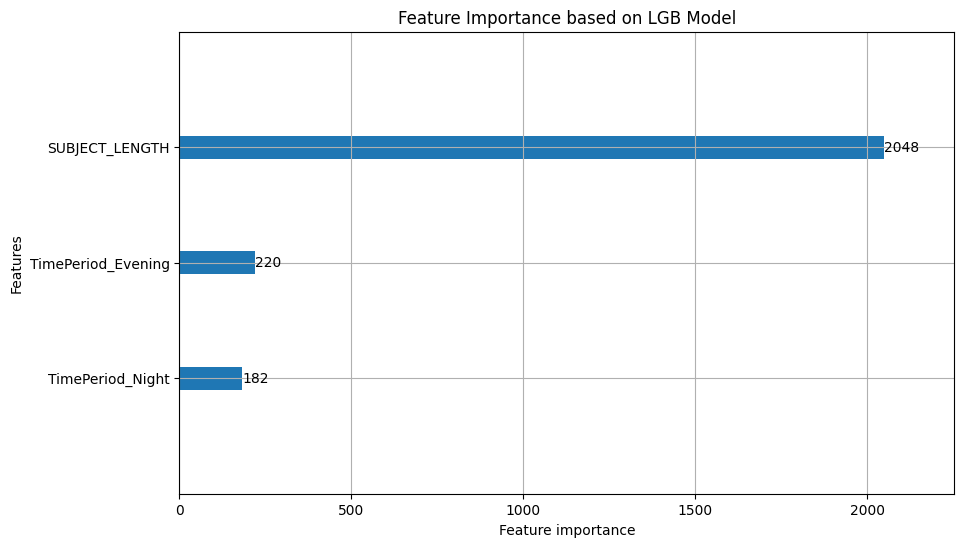

In [71]:
#===========================Feature Importance Graph based on Light GBM==================================
lgb.plot_importance(model, figsize=(10, 6), max_num_features=3)
plt.title('Feature Importance based on LGB Model')
plt.show()
#========================================================================================================

In [35]:
#=======================Classification Report based on LGB after applying SMOTE===================
report_lgb = classification_report(y_test, y_pred_binary)
print(report_lgb)
#=================================================================================================

              precision    recall  f1-score   support

           0       0.88      0.75      0.81   1322958
           1       0.26      0.48      0.34    249336

    accuracy                           0.71   1572294
   macro avg       0.57      0.61      0.58   1572294
weighted avg       0.79      0.71      0.74   1572294



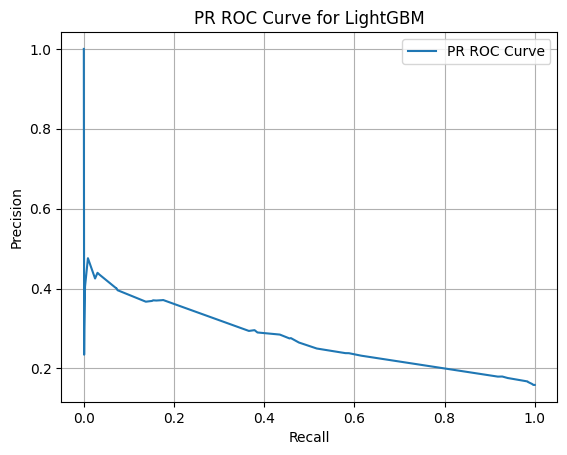

In [36]:
#============================PR ROC Curve for lightGBM model=============================================
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_lgb)
plt.plot(recall, precision, label='PR ROC Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR ROC Curve for LightGBM')
plt.legend()
plt.grid()
plt.show()
#=======================================================================================================

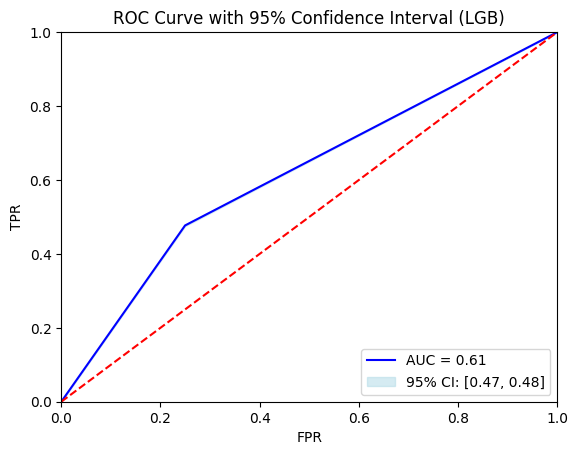

In [37]:
#============================ROC Curve for lightGBM model=============================================
fpr, tpr, thresholds = roc_curve(y_test, y_pred_binary)
roc_auc = auc(fpr, tpr)

# Standard error from TPR
std_err = np.sqrt((tpr * (1 - tpr)) / y_test.sum())

# Confidence interval 
confidence_level = 0.95
z_score = 1.96  # Z Score to a 95% confidence interval
upper_bound = tpr + std_err * z_score
lower_bound = tpr - std_err * z_score

# Plot the ROC curve with confidence interval
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'AUC = {roc_auc:.2f}')
plt.fill_between(fpr, lower_bound, upper_bound, color='lightblue', alpha=0.5,
                 label=f'95% CI: [{lower_bound[1]:.2f}, {upper_bound[1]:.2f}]')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve with 95% Confidence Interval (LGB)')
plt.legend(loc='lower right')
plt.show()

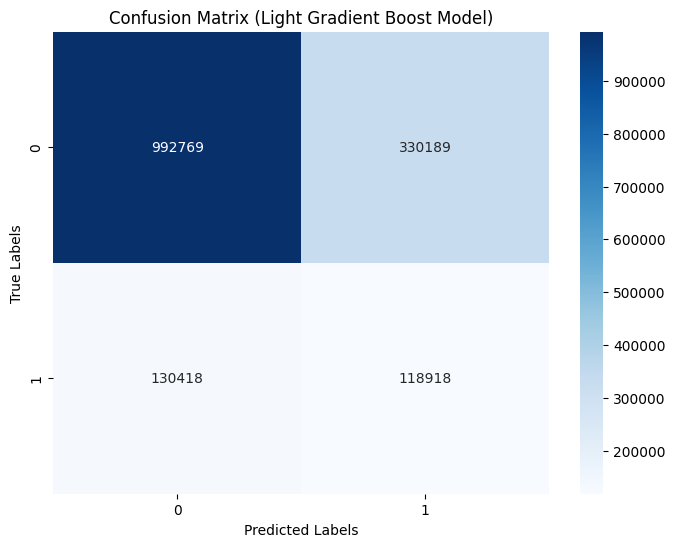

In [38]:
#===============================Confusion Matrix LGB=======================
cm = confusion_matrix(y_test, y_pred_binary)
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix (Light Gradient Boost Model)')
plt.show()
#=========================================================================

In [39]:
#==========================Random Forest Model after applying SMOTE========================
clf_RF = RandomForestClassifier(n_estimators = 100, max_depth = 10,  min_samples_split = 10)
clf_RF.fit(X_train_smote, y_train_smote)
# Making predictions on the testing data
y_pred_RF = clf_RF.predict(X_test)
# Evaluating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_RF)
# Calculate the execution time
print(f'Accuracy score(Random Forest Model): {accuracy}')
#==========================================================================================

Accuracy score(Random Forest Model): 0.7066865357242348


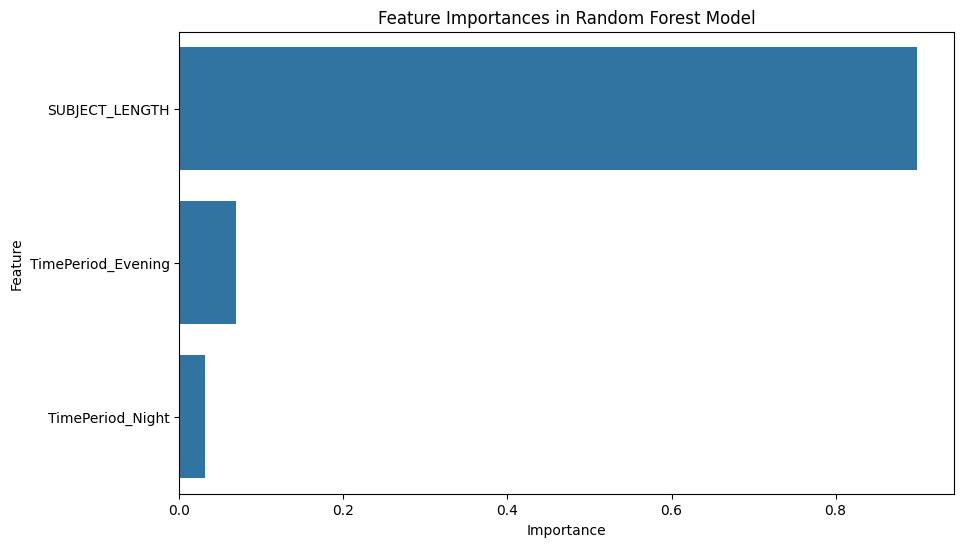

In [40]:
#=========================Feature Importance for Random Forest=======================
feature_importances = clf_RF.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importances in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
#=======================================================================================

In [41]:
#=======================Random Forest Classification Report============================
report_rf = classification_report(y_test, y_pred_RF)
print(report_rf)
#======================================================================================

              precision    recall  f1-score   support

           0       0.88      0.75      0.81   1322958
           1       0.26      0.48      0.34    249336

    accuracy                           0.71   1572294
   macro avg       0.57      0.61      0.58   1572294
weighted avg       0.79      0.71      0.74   1572294



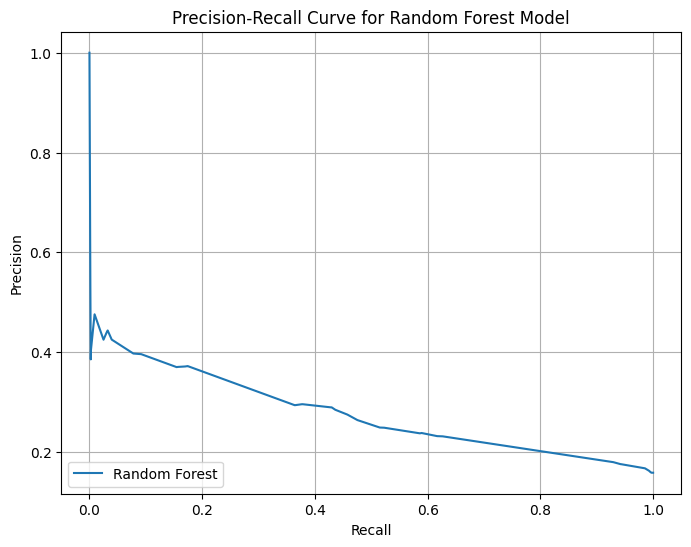

In [47]:
#================================PR ROC Curve for Random Forest Model======================
y_pred_prob = clf_RF.predict_proba(X_test)[:, 1]
precision_dt ,recall_dt, thresholds_dt = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall_dt, precision_dt, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest Model')
plt.legend(loc='lower left')
plt.grid()
plt.show()
#==============================================================================================

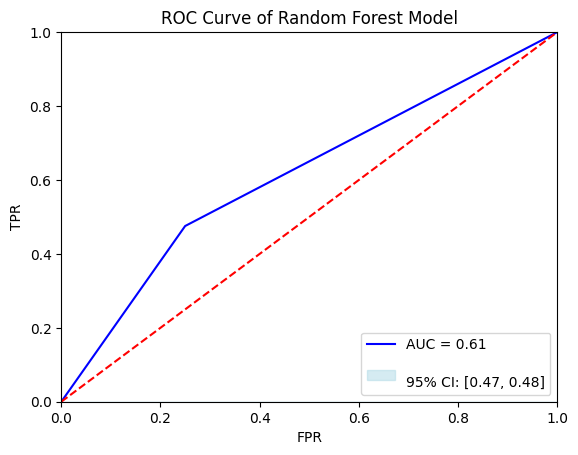

In [56]:
#===============================ROC Curve for Random Forest===============================================
fpr, tpr, thresholds = roc_curve(y_test, y_pred_RF)
roc_auc = auc(fpr, tpr)
# Compute the confidence interval
std_err = np.sqrt(np.divide(tpr * (1 - tpr), y_test.size, where=(y_test.size != 0)) * (fpr + tpr))
# Compute the confidence interval with explicit broadcasting
upper_bound = tpr + std_err * 1.96
lower_bound = tpr - std_err * 1.96
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='b', label='AUC = %0.2f' % roc_auc)
plt.fill_between(fpr, lower_bound, upper_bound, color='lightblue', alpha=0.5,label = '\n95%% CI: [%0.2f, %0.2f]' % (lower_bound[1], upper_bound[1]))
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve of Random Forest Model')
plt.legend(loc="lower right")
plt.show()

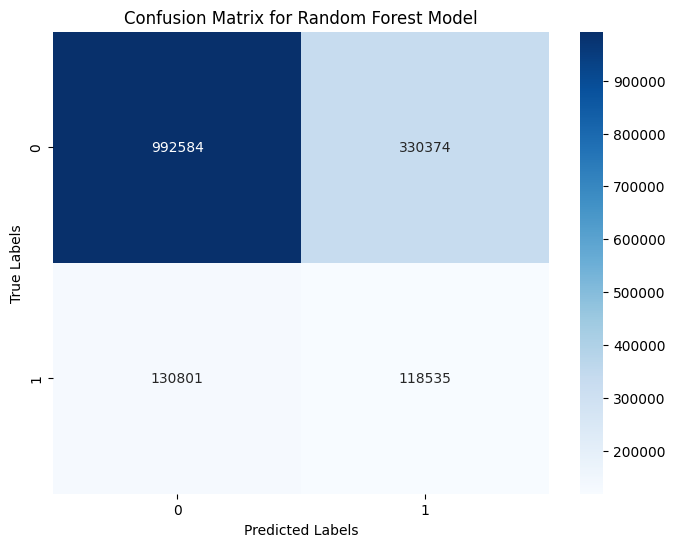

In [57]:
#============================Confusion Matrix for Random Forest model===============================
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_RF)
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()
#===================================================================================================

In [58]:
#======================================Gradient Boosting Model after applying SMOTE============================
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
gbm.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_gbm = gbm.predict(X_test)        

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_gbm)
print("Accuracy Score(Gradient Boosting Model):", accuracy)
#=====================================================================================================

Accuracy Score(Gradient Boosting Model): 0.707066871717376


In [59]:
#=======================Gradient Boosting Classification Report===========================
report_gbm = classification_report(y_test, y_pred_gbm)
print(report_gbm)
#=========================================================================================

              precision    recall  f1-score   support

           0       0.88      0.75      0.81   1322958
           1       0.26      0.48      0.34    249336

    accuracy                           0.71   1572294
   macro avg       0.57      0.61      0.58   1572294
weighted avg       0.79      0.71      0.74   1572294



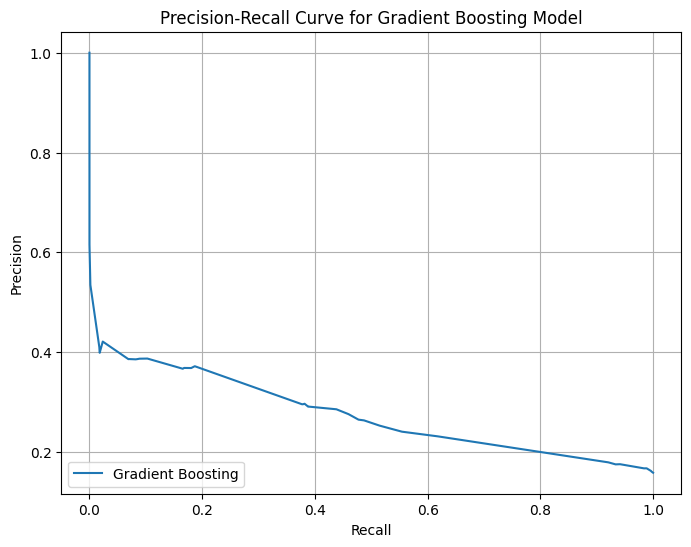

In [60]:
#================================PR ROC Curve for Gradient Boosting Model======================
y_pred_prob = gbm.predict_proba(X_test)[:, 1]
precision_dt ,recall_dt, thresholds_dt = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall_dt, precision_dt, label='Gradient Boosting')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Gradient Boosting Model')
plt.legend(loc='lower left')
plt.grid()
plt.show()
#==============================================================================================

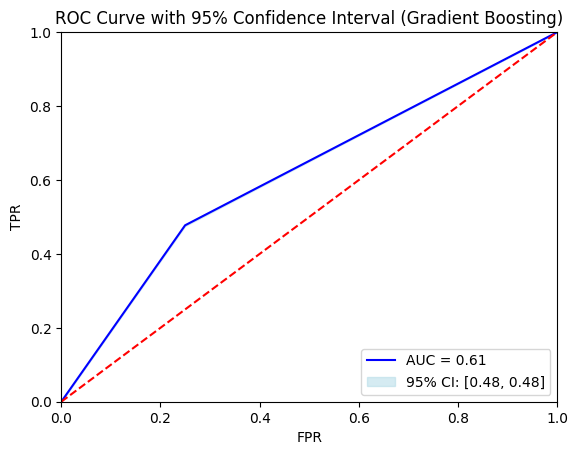

In [62]:
#===============================ROC Curve for Gradient Boosting===============================================
fpr, tpr, thresholds = roc_curve(y_test, y_pred_gbm)
roc_auc = auc(fpr, tpr)

# Standard error from TPR
std_err = np.sqrt((tpr * (1 - tpr)) / y_test.sum())

# Confidence interval
confidence_level = 0.95
z_score = 1.96  # Z socre for 95% confidence interval
upper_bound = tpr + std_err * z_score
lower_bound = tpr - std_err * z_score

# Plot the ROC curve with confidence interval
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'AUC = {roc_auc:.2f}')
plt.fill_between(fpr, lower_bound, upper_bound, color='lightblue', alpha=0.5,
                 label=f'95% CI: [{lower_bound[1]:.2f}, {upper_bound[1]:.2f}]')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve with 95% Confidence Interval (Gradient Boosting)')
plt.legend(loc='lower right')
plt.show()
#=============================================================================================

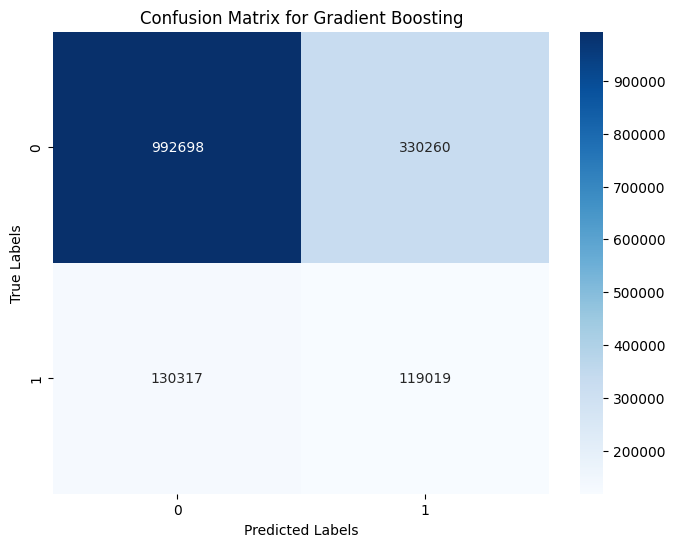

In [63]:
#===========================Confusion Matrix with Gradient Boosting===========================
cm = confusion_matrix(y_test, y_pred_gbm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Gradient Boosting')
plt.show()
#==============================================================================================

In [64]:
#===============================Logistic Regression after applying SMOTE===================================
clf_LR = LogisticRegression()

# Fitting the classifier to the training data
clf_LR.fit(X_train_smote, y_train_smote)

# Making predictions on the testing data
y_pred_LR = clf_LR.predict(X_test)

# Evaluating the accuracy of the model
accuracy_LR = accuracy_score(y_test, y_pred_LR)
print("Accuracy:", accuracy_LR)
#=========================================================================================================

Accuracy: 0.6850493609973707


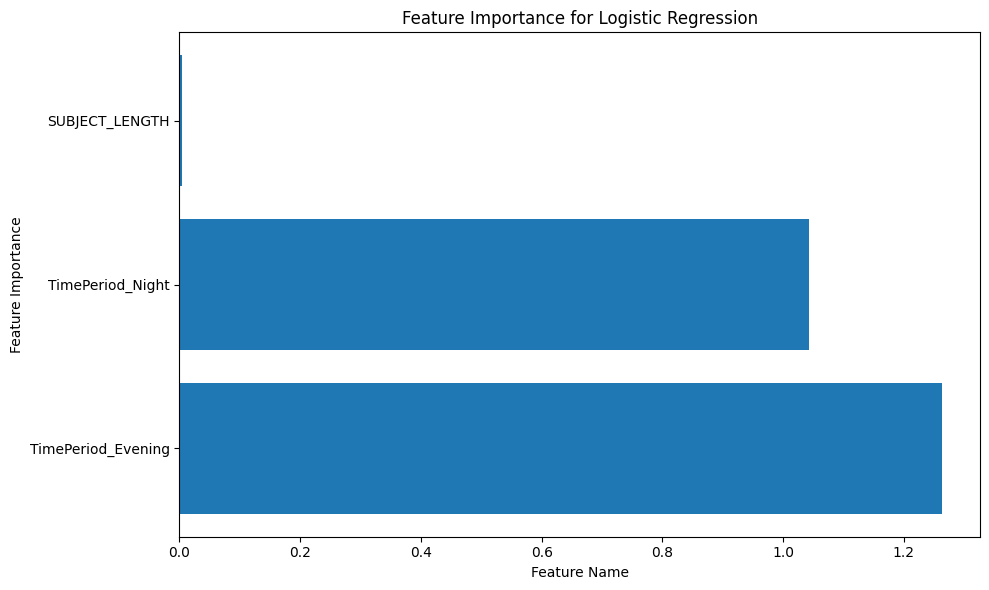

In [65]:
#======================Feature Importance based on Logistic Regression======================================
coefficients = clf_LR.coef_[0]

# Sort the coefficients by absolute value
sorted_coefficients = sorted(zip(X.columns, coefficients), key=lambda x: abs(x[1]), reverse=True)

# Create the feature importance graph
feature_names = [x[0] for x in sorted_coefficients]
feature_importances = [abs(x[1]) for x in sorted_coefficients]
plt.figure(figsize=(10, 6))
plt.barh(feature_names,feature_importances)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for Logistic Regression')
plt.tight_layout()
plt.show()
#==========================================================================================================

In [66]:
#====================================Logistic Regression Classification Report===============
report_LR = classification_report(y_test, y_pred_LR)
print(report_LR)
#==============================================================================================

              precision    recall  f1-score   support

           0       0.86      0.74      0.80   1322958
           1       0.22      0.38      0.28    249336

    accuracy                           0.69   1572294
   macro avg       0.54      0.56      0.54   1572294
weighted avg       0.76      0.69      0.72   1572294



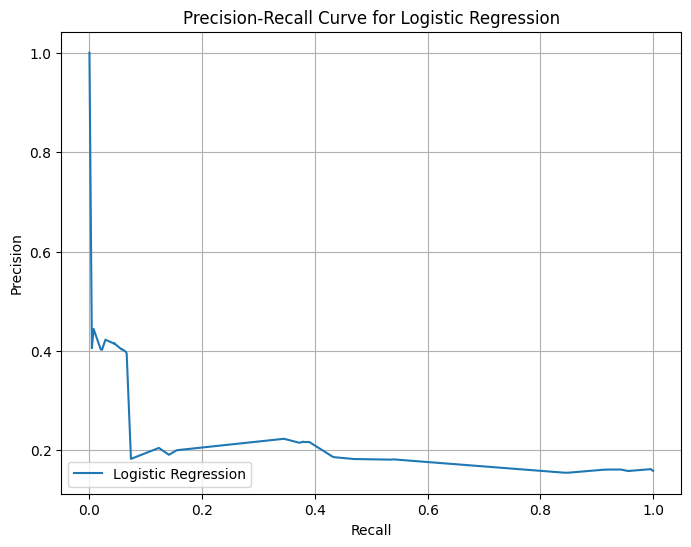

In [67]:
#==========================PR-ROC Curve Logistic Regression=========================
y_scores = clf_LR.predict_proba(X_test)[:, 1]
precision_dt ,recall_dt, thresholds_dt = precision_recall_curve(y_test, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(recall_dt, precision_dt, label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend(loc='lower left')
plt.grid()
plt.show()
#====================================================================================

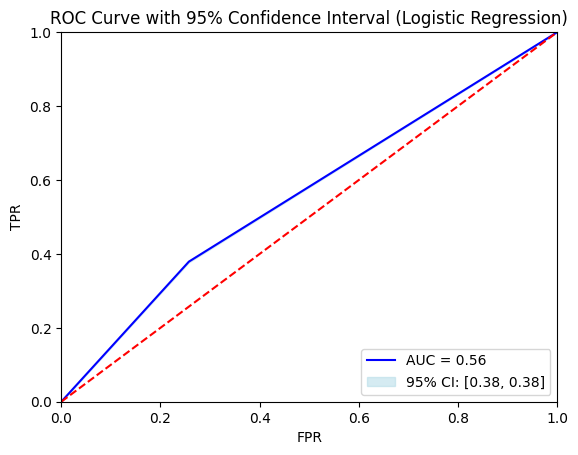

In [68]:
#==========================ROC Curve Logistic Regression==========================
fpr, tpr, thresholds = roc_curve(y_test, y_pred_LR)
roc_auc = auc(fpr, tpr)

# Standard error from TPR
std_err = np.sqrt((tpr * (1 - tpr)) / y_test.sum())

# Confidence interval
confidence_level = 0.95
z_score = 1.96  # Z socre for 95% confidence interval
upper_bound = tpr + std_err * z_score
lower_bound = tpr - std_err * z_score

# Plot the ROC curve with confidence interval
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'AUC = {roc_auc:.2f}')
plt.fill_between(fpr, lower_bound, upper_bound, color='lightblue', alpha=0.5,
                 label=f'95% CI: [{lower_bound[1]:.2f}, {upper_bound[1]:.2f}]')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve with 95% Confidence Interval (Logistic Regression)')
plt.legend(loc='lower right')
plt.show()

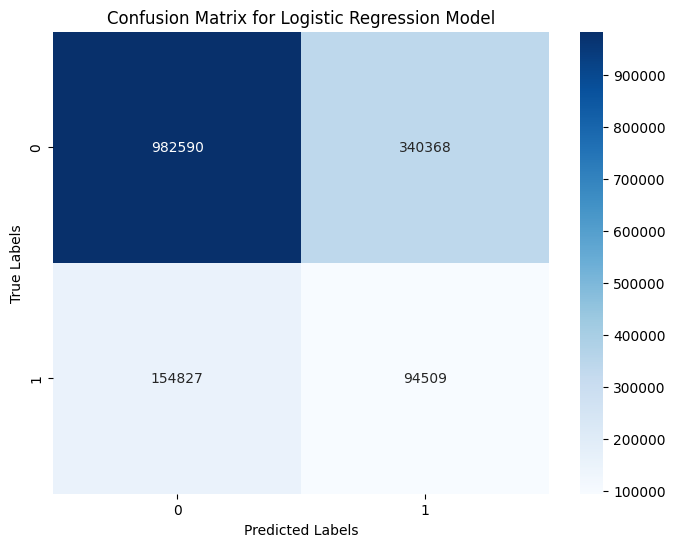

In [69]:
#==================================Confusion Matrix for Logistic Regression==================
cm = confusion_matrix(y_test, y_pred_LR)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()
#==============================================================================================